In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import ROOT.RooFit as rf
from array import array
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from gridVarQ2Plot import col_dic
from analysis_utilities import drawOnCMSCanvas
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [6]:
loc = '../data/cmsRD/'
loc += 'ParkingBPH*/'
loc += 'Run2018D-05May2019promptD-v1_RDntuplizer_TagAndProbe_Bp2MuNuDstst_Pip_200522_CAND.root'

tData = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tData.Add(floc)

print 'N evts: {:.0f}'.format(tData.GetEntries())

N evts: 1314401


In [7]:
def addOverflow(hh):
    Nbins = hh.GetNbinsX()
    hh.SetBinContent(Nbins, hh.GetBinContent(Nbins) + hh.GetBinContent(Nbins+1))
    hh.SetBinContent(Nbins+1, 0)
    return

In [8]:
def appendNewHisto(var, h_list, cuts, addCuts, leg=None, overflow=True):
    lastName = h_list[-1].GetName()
    if lastName == 'h':
        N =1
    else:
        N = 1 + int(lastName[1:])
        
    hAux = create_TH1D(np.zeros(0), name='h'+str(N), binning=h_list[0].binning)
    tData.Project('h'+str(N), var, cuts + ' && ' + addCuts)
    hAux.SetLineColor(col_dic.values()[N-1])
    hAux.Sumw2()
    if overflow:
        addOverflow(hAux)
    hAux.SetLineWidth(2)
    h_list.append(hAux)
    
    if not leg is None:
        leg.AddEntry(hAux, addCuts, 'lep')
    
    return h_list

# Cuts declaration

In [9]:
cut_general = [
    'n_B == 1',
    'trgMu_pt > 7',
    'trgMu_sigdxy > 4',
    'abs(trgMu_eta) < 1.5',
]

$D_0$ reconstruction

In [10]:
cut_piK = [
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - 1.864) < 0.05',
'sigdxy_vtxD0_PV > 2'
]

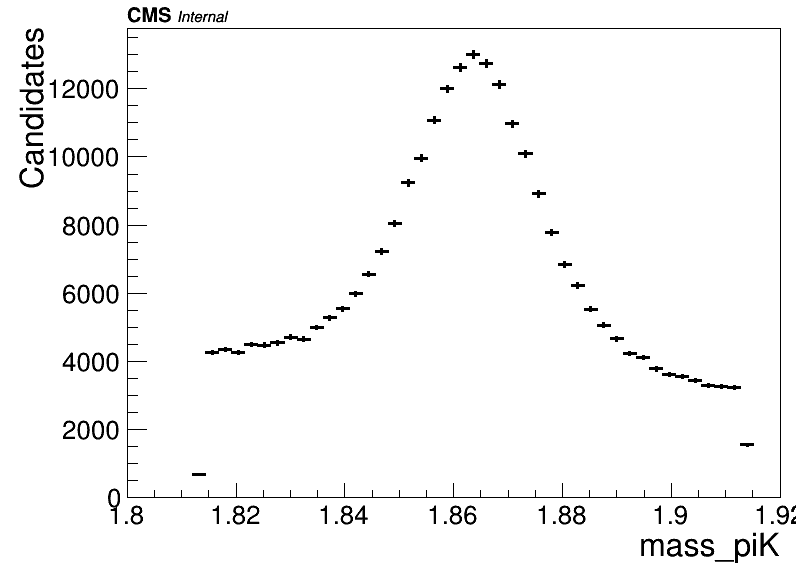

In [11]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
addOverflow(h)
# h.Scale(1./h.Integral())
h.SetLineWidth(3)
h_list=[h]

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')

<ROOT.TLine object ("TLine") at 0xcebd760>

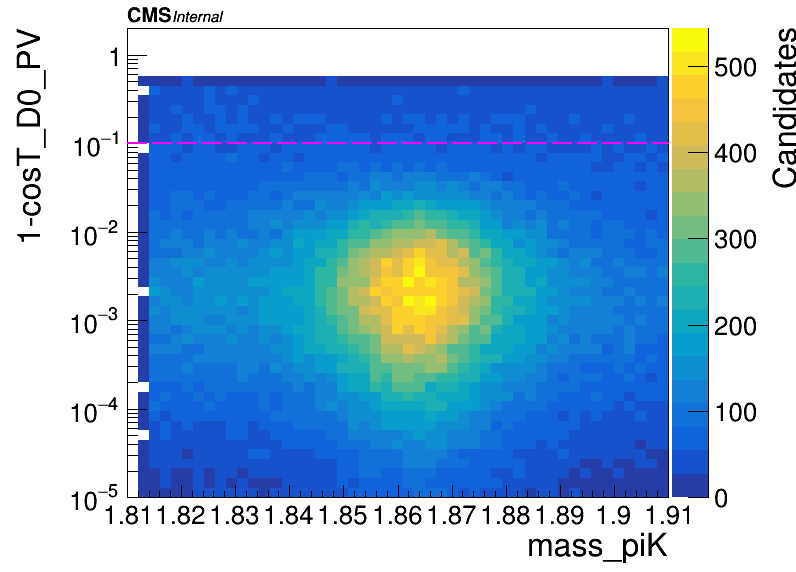

In [12]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', '1-cosT_D0_PV', 'Candidates'],
                binning=[np.linspace(1.81, 1.91, 50), np.logspace(-5, np.log10(2), 50)] )
tData.Project('h', '1 - cosT_D0_PV:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()
cl.DrawLine(1.81, 0.1, 1.91, 0.1)

<ROOT.TLine object ("TLine") at 0xce69b30>

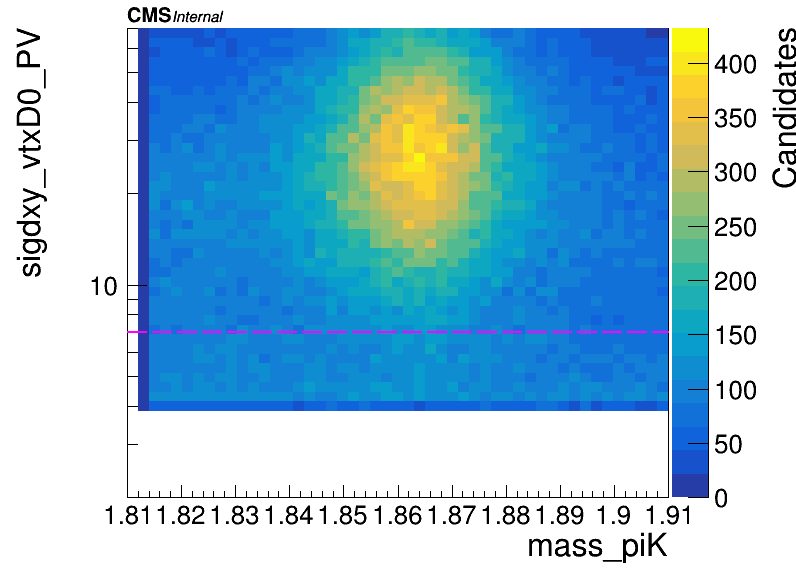

In [13]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass_piK', 'sigdxy_vtxD0_PV', 'Candidates'],
                binning=[np.linspace(1.81, 1.91, 50), np.logspace(np.log10(2), np.log10(70), 50)] )
tData.Project('h', 'sigdxy_vtxD0_PV:mass_piK', cuts)
# h.Sumw2()
# h.Scale(1./h.Integral())

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()
cl.DrawLine(1.81, 7, 1.91, 7)

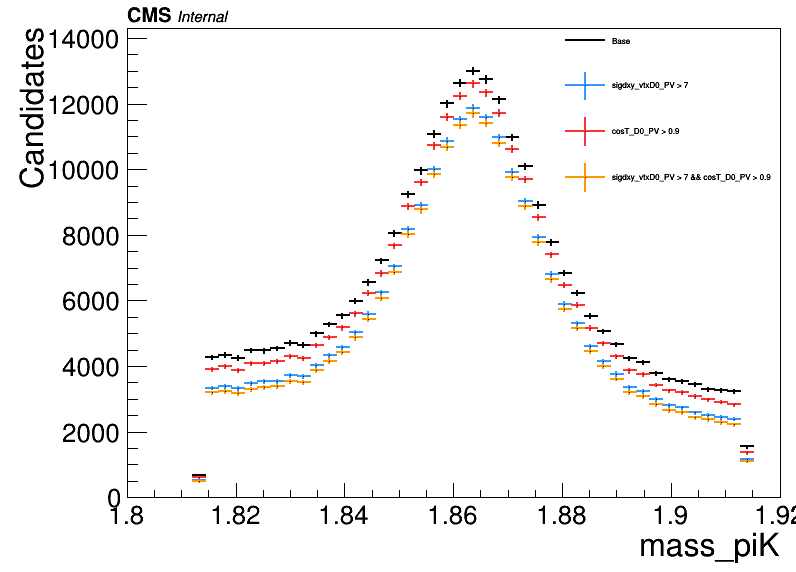

In [14]:
cuts = ' && '.join(cut_general+cut_piK)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
addOverflow(h)
h.SetLineWidth(2)
h_list=[h]

leg = rt.TLegend(0.7, 0.65, 0.98, 0.97)
leg.AddEntry(h, 'Base', 'l')
leg.SetTextFont(42)
leg.SetFillStyle(0)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

appendNewHisto('mass_piK', h_list, cuts, 'sigdxy_vtxD0_PV > 7', leg=leg)
appendNewHisto('mass_piK', h_list, cuts, 'cosT_D0_PV > 0.9', leg=leg)
appendNewHisto('mass_piK', h_list, cuts, 'sigdxy_vtxD0_PV > 7 && cosT_D0_PV > 0.9', leg=leg)

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [15]:
cut_piK_rev = [
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
'abs(mass_piK - {}) < 0.035'.format(m_D0),
'sigdxy_vtxD0_PV > 7',
'cosT_D0_PV > 0.9'
]

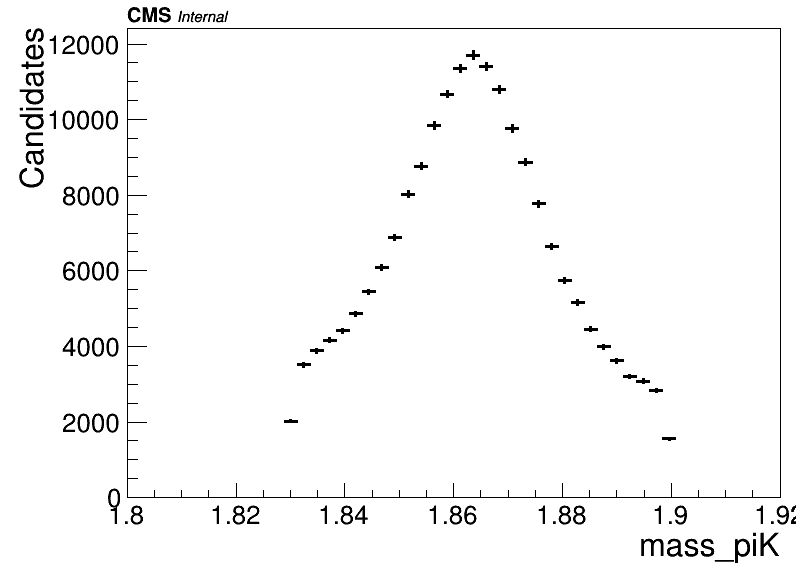

In [16]:
cuts = ' && '.join(cut_general+cut_piK_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass_piK', 'Candidates'],
                binning=[50, 1.8, 1.92] )
tData.Project('h', 'mass_piK', cuts)
h.Sumw2()
h.SetLineWidth(3)
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

In [17]:
tData.GetEntries(' && '.join(cut_general+cut_piK))

273044L

### $D^{**}$ Recostruction

In [18]:
cut_D0pipmu = [
'pip_pt > 0.5',
'abs(pip_eta) < 2.4',
'
    < {}'.format(m_B0),
'pval_D0pipmu > 0.1',
]

In [19]:
tData.GetEntries(' && '.join(cut_general+cut_piK+cut_D0pipmu))

189689L

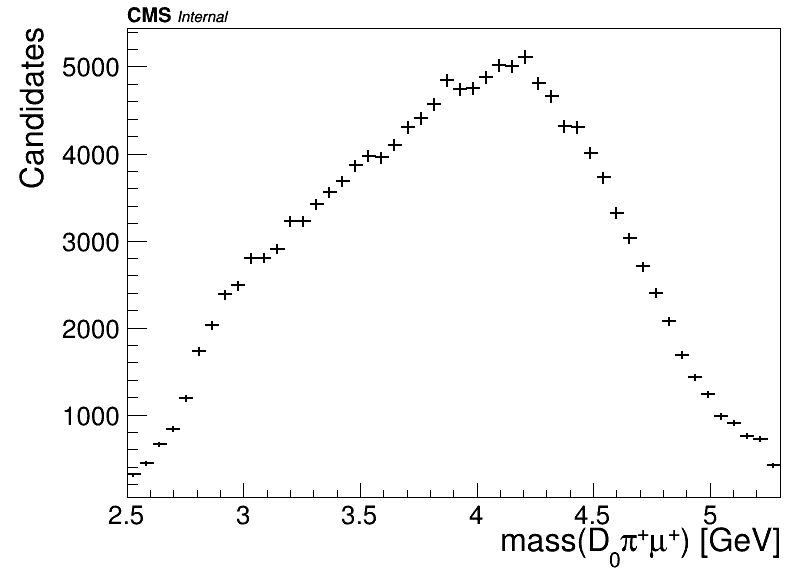

In [20]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}#pi^{+}#mu^{+}) [GeV]', 'Candidates'],
                binning=[50, 2.5, 5.3] )
tData.Project('h', 'mass_D0pipmu', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

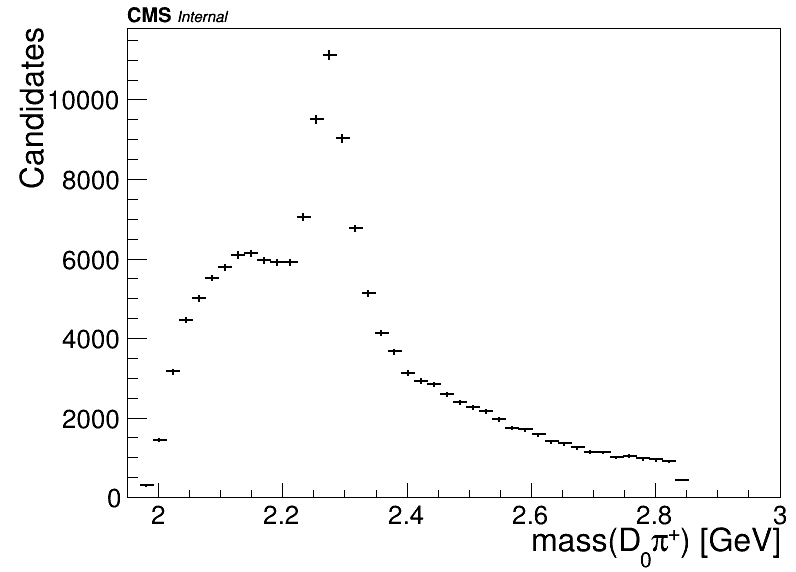

In [21]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 1.95, 3.] )
tData.Project('h', 'mass_D0pip', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

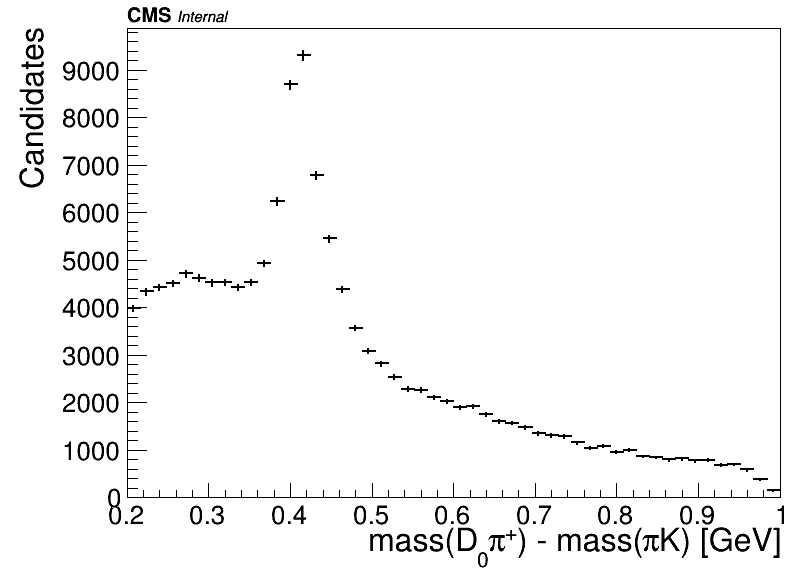

In [22]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}#pi^{+}) - mass(#piK) [GeV]', 'Candidates'],
                binning=[50, 0.2, 1] )
tData.Project('h', 'mass_D0pip-mass_piK', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

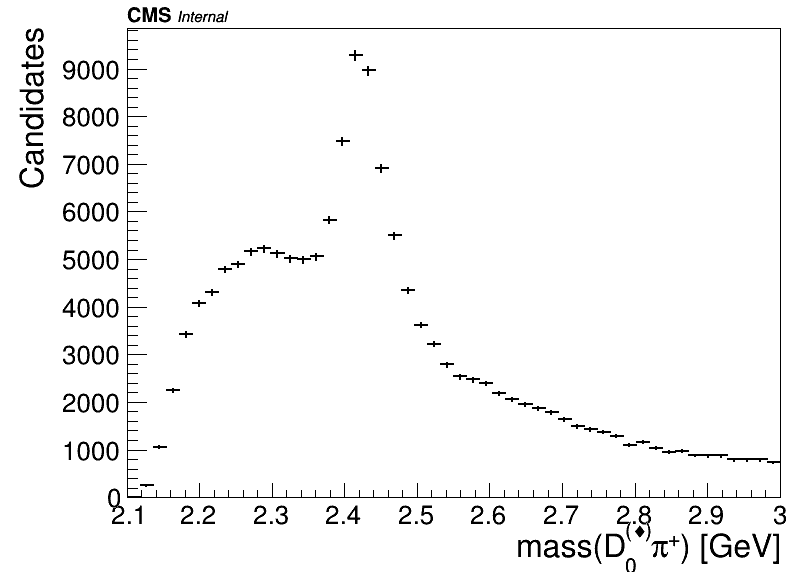

In [23]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 2.1, 3.] )
tData.Project('h', 'mass_expDstpip', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

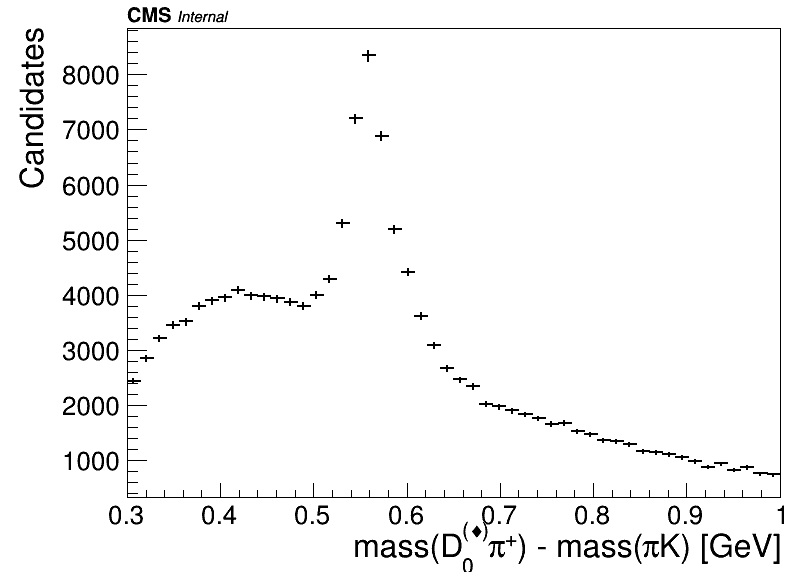

In [24]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) - mass(#piK) [GeV]', 'Candidates'],
                binning=[50, 0.3, 1] )
tData.Project('h', 'dm_expDstpip_pik', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

<ROOT.TLine object ("TLine") at 0xcf56150>

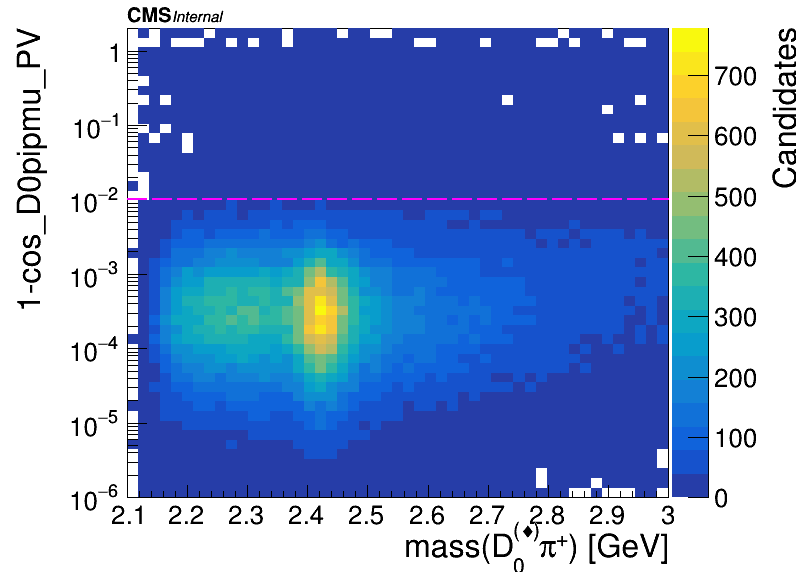

In [25]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', '1-cos_D0pipmu_PV', 'Candidates'],
                binning=[np.linspace(2.1, 3, 50), np.logspace(-6, np.log10(2), 50)] )
tData.Project('h', '1-cos_D0pipmu_PV:mass_expDstpip', cuts)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()
cl.DrawLine(2.1, 0.01, 3, 0.01)

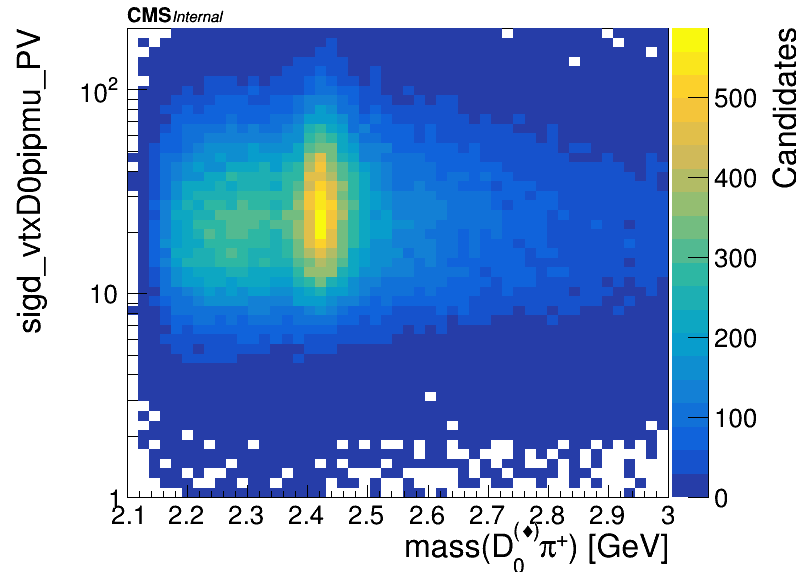

In [26]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', 'sigd_vtxD0pipmu_PV', 'Candidates'],
                binning=[np.linspace(2.1, 3, 50), np.logspace(0, np.log10(200), 50)] )
tData.Project('h', 'sigd_vtxD0pipmu_PV:mass_expDstpip', cuts)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)
c.SetLogy()

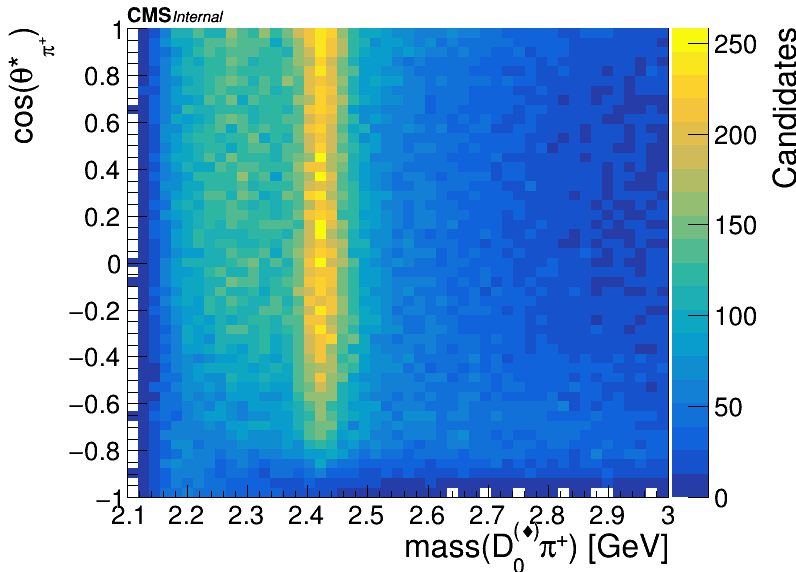

In [27]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', 'cos(#theta*_{#pi^{+}})', 'Candidates'],
                binning=[np.linspace(2.1, 3, 50), np.linspace(-1, 1, 50)] )
tData.Project('h', 'CosThetaSt_pip:mass_expDstpip', cuts)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

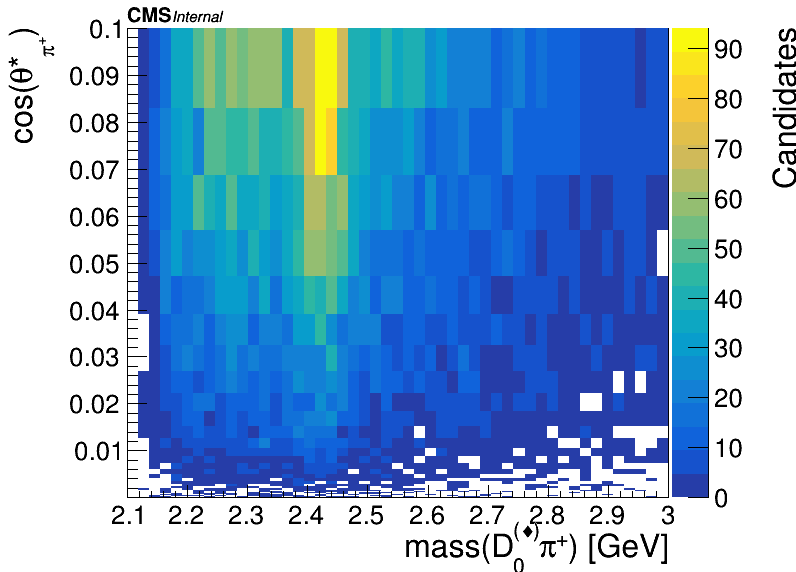

In [48]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', 'cos(#theta*_{#pi^{+}})', 'Candidates'],
                binning=[np.linspace(2.1, 3, 50), np.logspace(-5, -1, 50)] )
tData.Project('h', '1-CosThetaSt_pip:mass_expDstpip', cuts)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

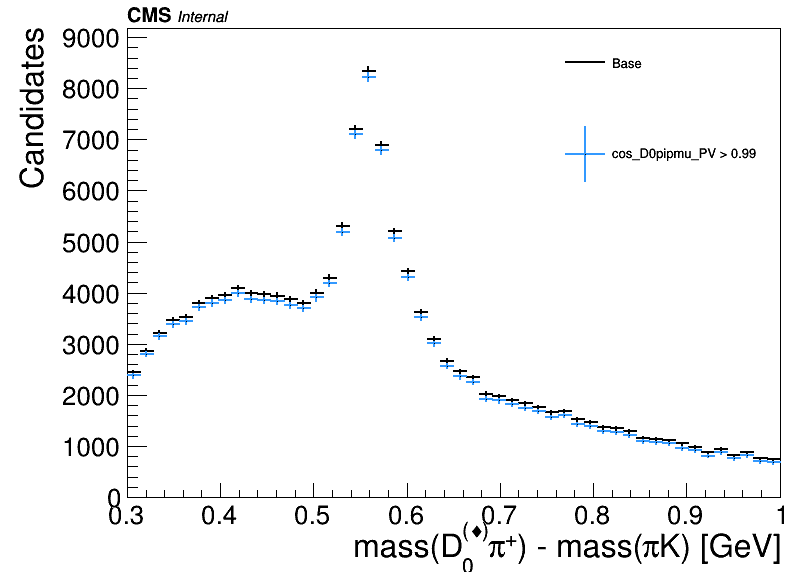

In [28]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) - mass(#piK) [GeV]', 'Candidates'],
                binning=[50, 0.3, 1] )
tData.Project('h', 'mass_expDstpip-mass_piK', cuts)
h.Sumw2()
h.SetLineWidth(2)
h_list=[h]

leg = rt.TLegend(0.7, 0.65, 0.98, 0.97)
leg.AddEntry(h, 'Base', 'l')
leg.SetTextFont(42)
leg.SetFillStyle(0)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

appendNewHisto('mass_expDstpip-mass_piK', h_list, cuts, 'cos_D0pipmu_PV > 0.99', leg=leg, overflow=False)

m = SetMaxToMaxHist(h_list)
h_list[0].GetYaxis().SetRangeUser(0, m)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()

In [29]:
cut_D0pipmu_rev = [
'pip_pt > 0.5',
'abs(pip_eta) < 2.4',
'mass_D0pipmu < {}'.format(m_B0),
'pval_D0pipmu > 0.1',
'cos_D0pipmu_PV > 0.99'
]

In [30]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) - mass(#piK) [GeV]', 'Candidates'],
                binning=[50, 0.3, 1] )
tData.Project('h', 'dm_expDstpip_pik', cuts)
h.Sumw2()

In [31]:
xMin = 0.44
xMax = 0.9
xSigLow = 0.48
xSigHigh = 0.7

fBkg = rt.TF1('fBkg', 'pol3', xMin, xMax)
gBkg = rt.TGraphErrors()
for i in range(1,h.binning[0]+1):
    x = h.GetBinCenter(i)
    if (x > xMin and x < xSigLow) or (x > xSigHigh and x < xMax):
        y = h.GetBinContent(i)
        gBkg.SetPoint(i-1, x, y)
        gBkg.SetPointError(i-1, 0, h.GetBinError(i))
gBkg.Fit(fBkg, 's')


****************************************
Minimizer is Linear
Chi2                      =      12.7266
NDf                       =           13
p0                        =      8424.87   +/-   2938.34     
p1                        =     -10051.3   +/-   13564.4     
p2                        =     -1845.51   +/-   20030.5     
p3                        =      4223.92   +/-   9567.93     


Number of signal events: 22638


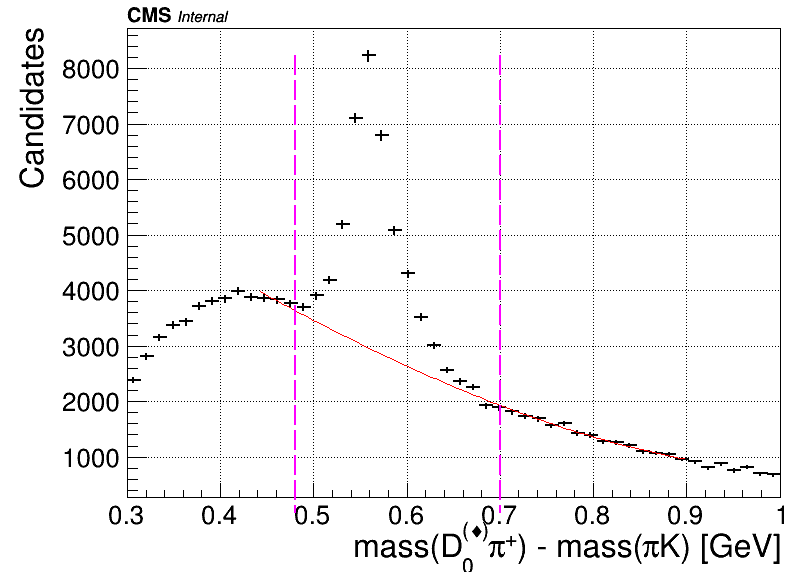

In [32]:
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetGrid()
fBkg.Draw('same')
cl.DrawLine(xSigLow, 0., xSigLow, h.GetMaximum())
cl.DrawLine(xSigHigh, 0., xSigHigh, h.GetMaximum())
nTot = 0
for i in range(1,h.binning[0]+1):
    x = h.GetBinCenter(i)
    if x > xSigLow and x < xSigHigh:
        nTot += h.GetBinContent(i) - fBkg.Eval(x)
print 'Number of signal events: {:.0f}'.format(nTot)

# Look for the soft $\pi$ from $D^*$

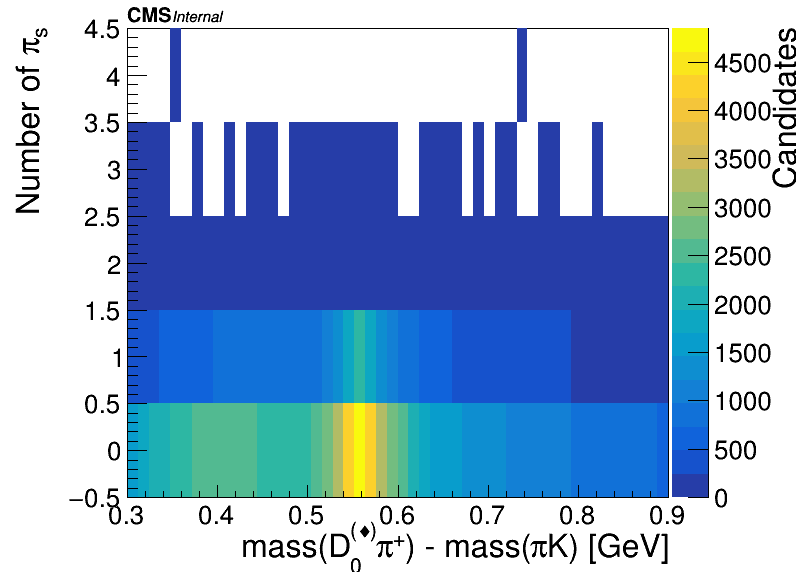

In [33]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) - mass(#piK) [GeV]', 'Number of #pi_{s}', 'Candidates'],
                binning=[50, 0.3, 0.9, 5, -0.5, 4.5] )
tData.Project('h', 'Sum$(chi2_D0pis>0):dm_expDstpip_pik', cuts)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

In [34]:
cut_D0pis = [
'pis_pt > 0.4',
'fabs(pis_eta) < 2.4',
'pval_D0pis > 0.1'
]

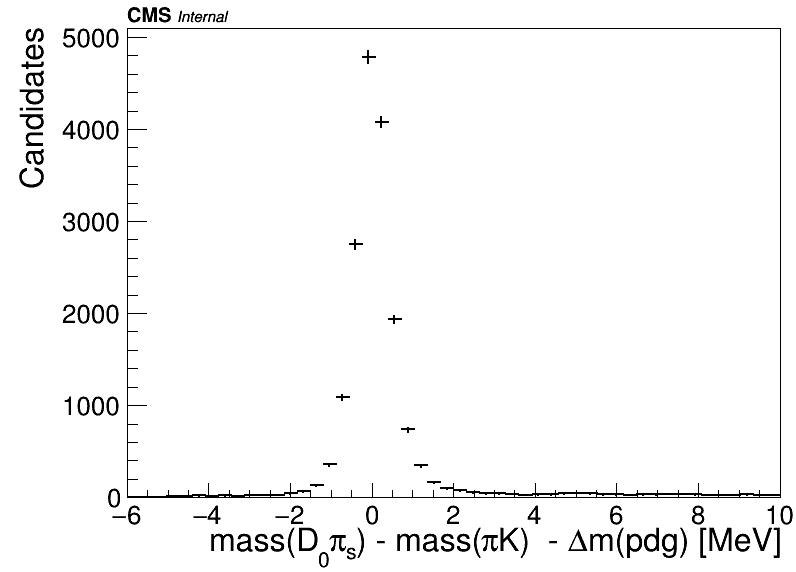

In [35]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}#pi_{s}) - mass(#piK)  - #Deltam(pdg) [MeV]', 'Candidates'],
                binning=[50, -6, 10] )
tData.Project('h', '1e3*(dm_D0pis_piK - {})'.format(m_Dst-m_D0), cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

In [36]:
nPass = tData.GetEntries('fabs(mass_D0pis-mass_piK - {}) < 2e-3'.format(m_Dst-m_D0) + ' && ' + cuts)
print 'Total tracking efficiecny: {:.0f}/{:.0f} = {:.1f}%'.format(nPass, nTot, 1e2*nPass/nTot)

Total tracking efficiecny: 16212/22638 = 71.6%


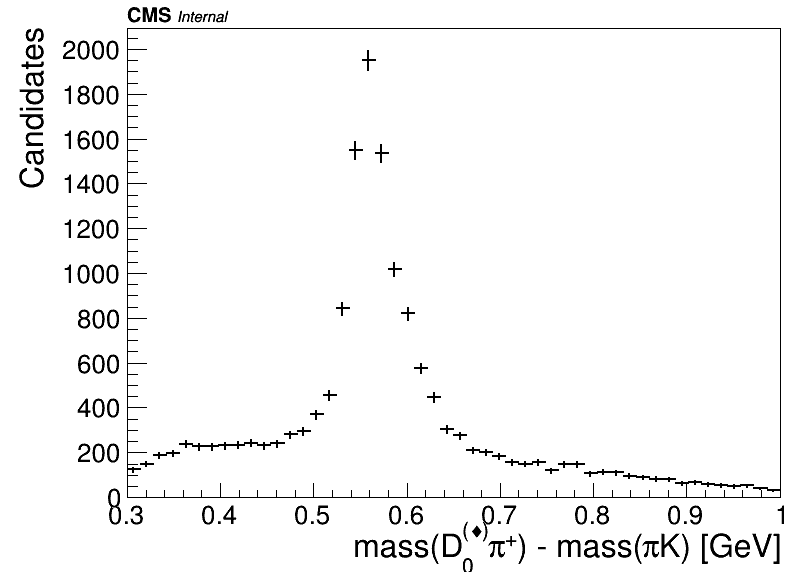

In [51]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) - mass(#piK) [GeV]', 'Candidates'],
                binning=[50, 0.3, 1] )
tData.Project('h', 'dm_expDstpip_pik', cuts + ' && fabs(mass_D0pis-mass_piK - {}) < 2e-3'.format(m_Dst-m_D0))
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

In a more accurate test, try to use ``RooChebychev`` to fit the background

# Study the MC

## Load the samples

In [37]:
loc = '../data/cmsMC_private/'
loc += 'BP_Tag_Bp_MuNuDstst_Hardbbbar_evtgen_ISGW2_PUc0_10-2-3/'
loc += 'ntuples_TagAndProbe_Bp_MuNuDstst/out_CAND_*.root'

tMC = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tMC.Add(floc)

print 'N evts: {:.0f}'.format(tMC.GetEntries())

N evts: 589938


## Plots

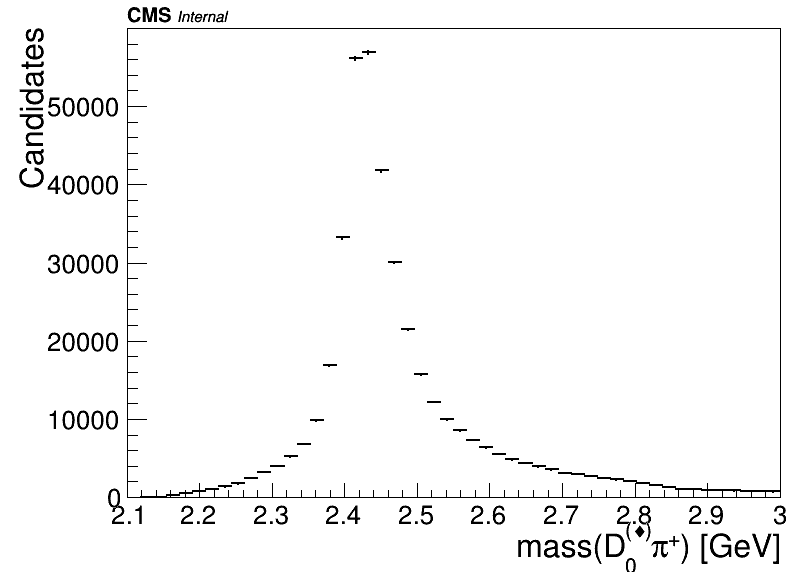

In [38]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', 'Candidates'],
                binning=[50, 2.1, 3.] )
tMC.Project('h', 'mass_expDstpip', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

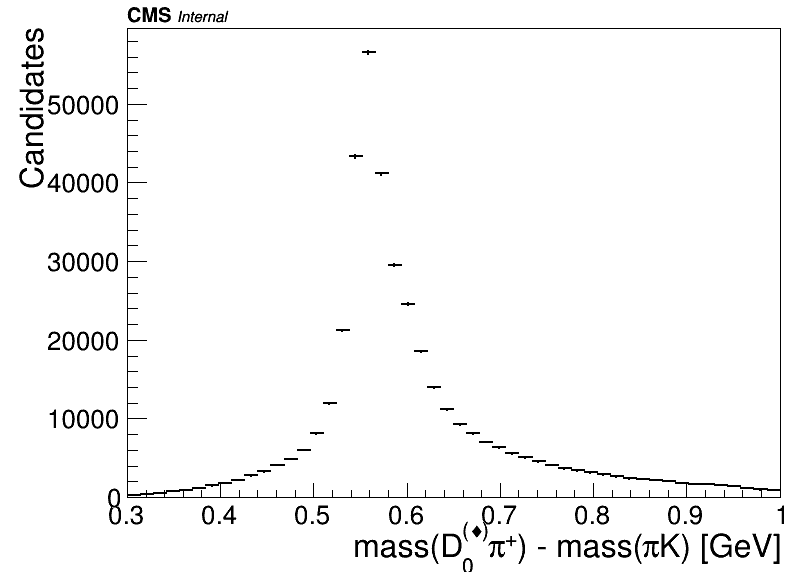

In [39]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) - mass(#piK) [GeV]', 'Candidates'],
                binning=[50, 0.3, 1] )
tMC.Project('h', 'dm_expDstpip_pik', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

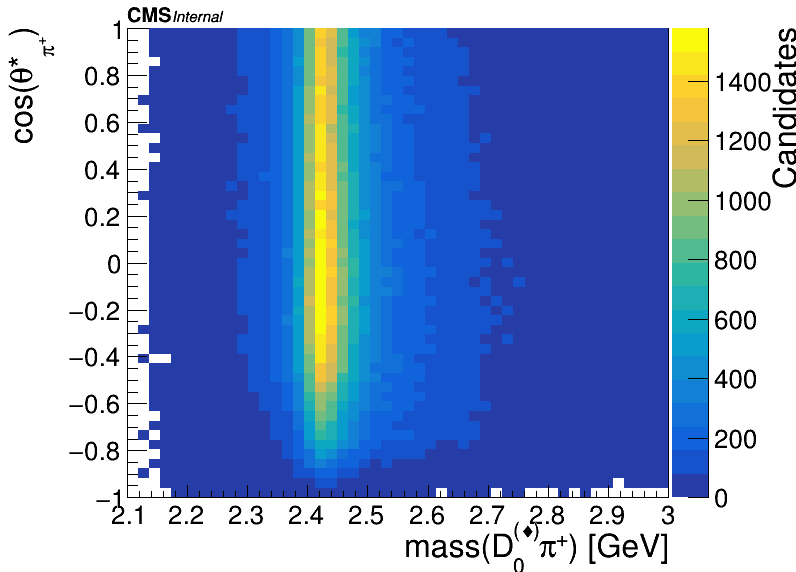

In [40]:
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['mass(D_{0}^{(#diamond)}#pi^{+}) [GeV]', 'cos(#theta*_{#pi^{+}})', 'Candidates'],
                binning=[np.linspace(2.1, 3, 50), np.linspace(-1, 1, 50)] )
tMC.Project('h', 'CosThetaSt_pip:mass_expDstpip', cuts)

c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

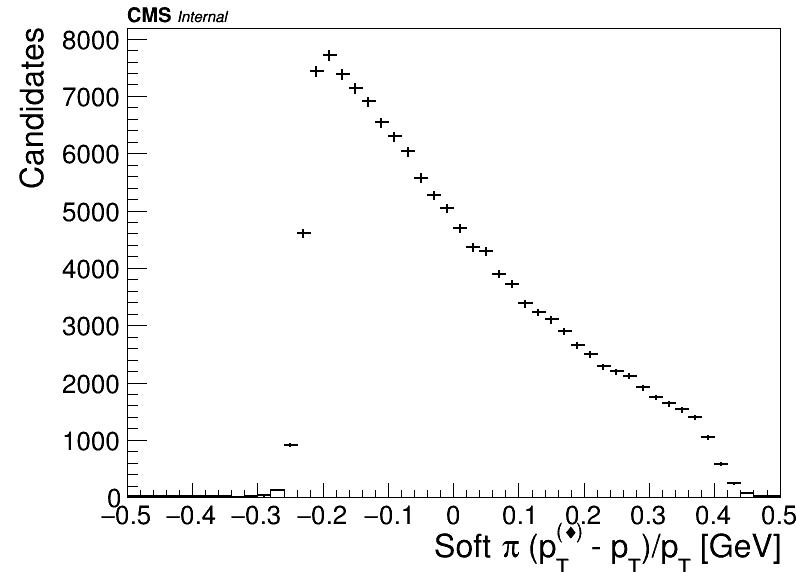

In [41]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH1D(np.zeros(0), name='h',
                title='', axis_title=['Soft #pi (p_{T}^{(#diamond)} - p_{T})/p_{T} [GeV]', 'Candidates'],
                binning=[50, -0.5, 0.5] )
tMC.Project('h', '(pis_expD0pipmu_pt - pis_refitD0pismu_pt)/pis_refitD0pismu_pt', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')

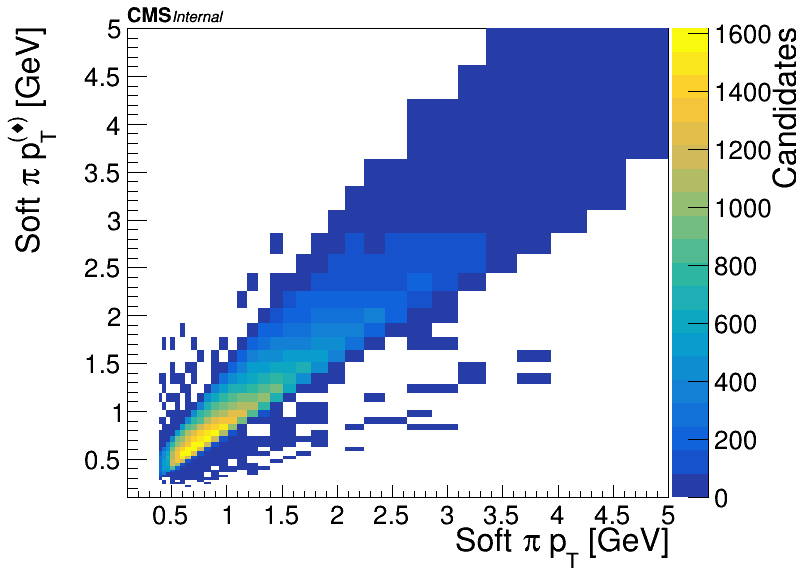

In [42]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['Soft #pi p_{T} [GeV]', 'Soft #pi p_{T}^{(#diamond)} [GeV]', 'Candidates'],
                binning=[np.logspace(-1, np.log10(5), 50), np.logspace(-1, np.log10(5), 50)])
tMC.Project('h', 'pis_expD0pipmu_pt:pis_refitD0pismu_pt', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

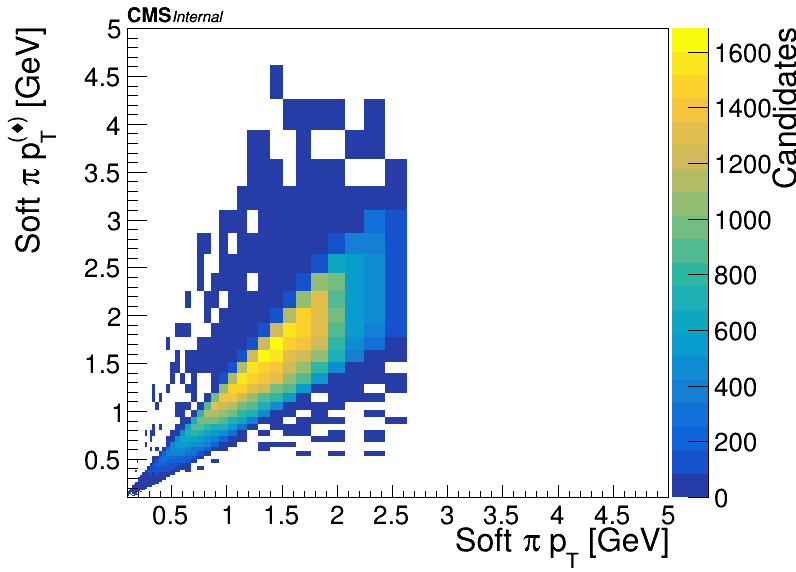

In [43]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['Soft #pi p_{T} [GeV]', 'Soft #pi p_{T}^{(#diamond)} [GeV]', 'Candidates'],
                binning=[np.logspace(-1, np.log10(5), 50), np.logspace(-1, np.log10(5), 50)])
tMC.Project('h', '1./pis_expD0pipmu_pt:1./pis_refitD0pismu_pt', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

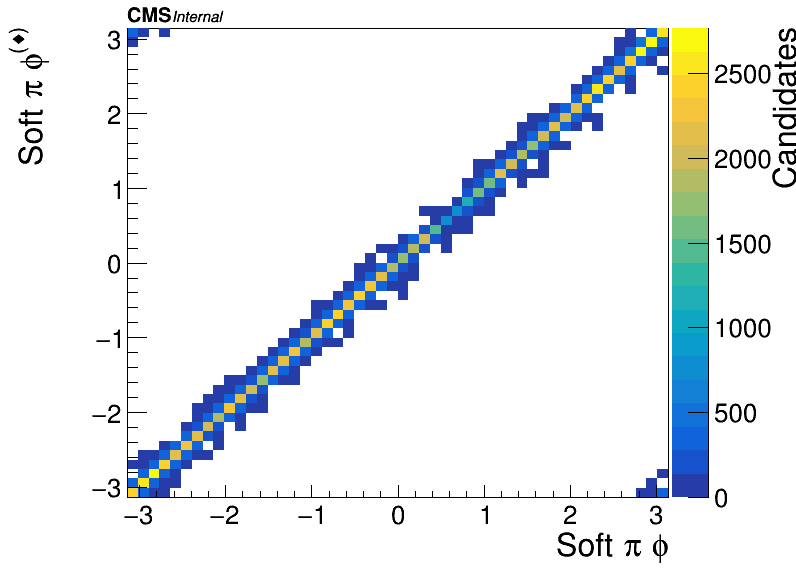

In [44]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['Soft #pi #phi', 'Soft #pi #phi^{(#diamond)}', 'Candidates'],
                binning=[50, -np.pi, np.pi, 50, -np.pi, np.pi]
               )
tMC.Project('h', 'pis_expD0pipmu_phi:pis_refitD0pismu_phi', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

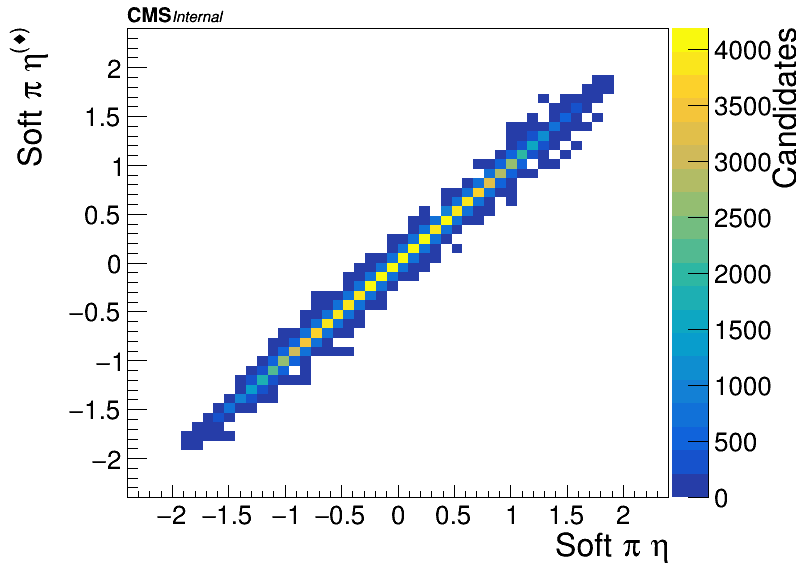

In [45]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['Soft #pi #eta', 'Soft #pi #eta^{(#diamond)}', 'Candidates'],
                binning=[50, -2.4, 2.4, 50, -2.4, 2.4]
               )
tMC.Project('h', 'pis_expD0pipmu_eta:pis_refitD0pismu_eta', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

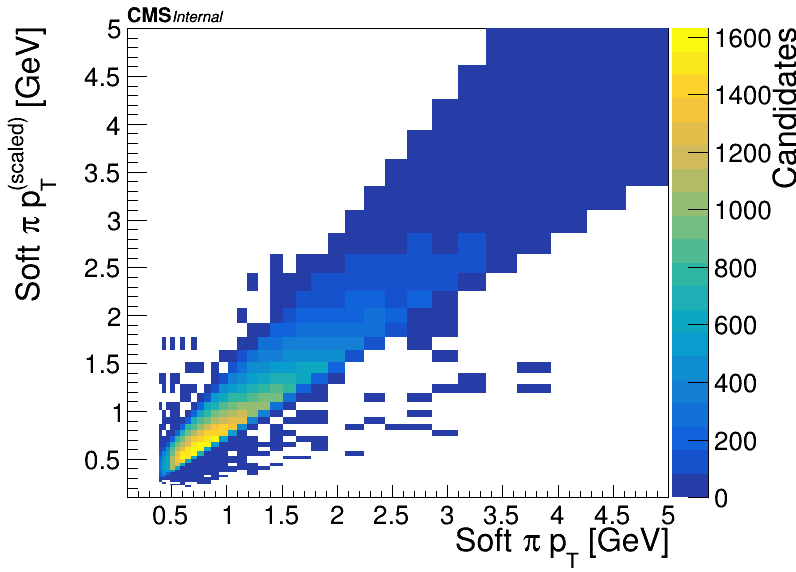

In [46]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['Soft #pi p_{T} [GeV]', 'Soft #pi p_{T}^{(scaled)} [GeV]', 'Candidates'],
                binning=[np.logspace(-1, np.log10(5), 50), np.logspace(-1, np.log10(5), 50)])
tMC.Project('h', 'pis_expScale_pt:pis_refitD0pismu_pt', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

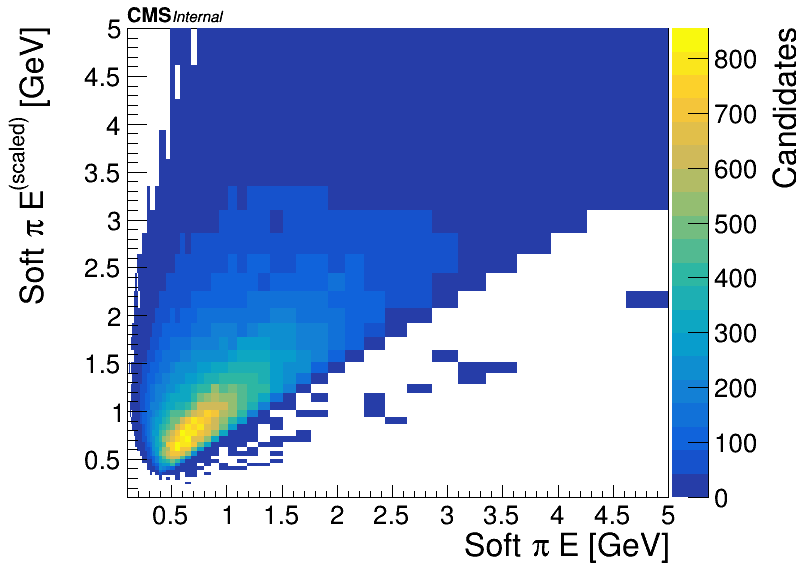

In [47]:
cuts = ' && '.join(cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis)
h = create_TH2D(np.zeros((0,2)), name='h',
                title='', axis_title=['Soft #pi E [GeV]', 'Soft #pi E^{(scaled)} [GeV]', 'Candidates'],
                binning=[np.logspace(-1, np.log10(5), 50), np.logspace(-1, np.log10(5), 50)])
tMC.Project('h', 'pis_expScale_E:pis_refitD0pismu_pt/cosh(pis_refitD0pismu_eta)', cuts)
h.Sumw2()
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], mR=0.16)

In [49]:
cut_general+cut_piK_rev+cut_D0pipmu_rev+cut_D0pis

['n_B == 1',
 'trgMu_pt > 7',
 'trgMu_sigdxy > 4',
 'abs(trgMu_eta) < 1.5',
 'K_pt > 0.8',
 'pi_pt > 0.8',
 'pval_piK > 0.1',
 'abs(K_eta) < 2.4',
 'abs(pi_eta) < 2.4',
 'abs(mass_piK - 1.86483) < 0.035',
 'sigdxy_vtxD0_PV > 7',
 'cosT_D0_PV > 0.9',
 'pip_pt > 0.5',
 'abs(pip_eta) < 2.4',
 'mass_D0pipmu < 5.27963',
 'pval_D0pipmu > 0.1',
 'cos_D0pipmu_PV > 0.99',
 'pis_pt > 0.4',
 'fabs(pis_eta) < 2.4',
 'pval_D0pis > 0.1']

In [50]:
m_Dst-m_D0

0.14543000000000017